# Regression Tasks

This notebook addresses the regression tasks for predicting Customer Lifetime Value (CLV_Continuous) using the FinTech dataset. We will build upon the preprocessing from Assignment 01 and apply various regression techniques.

## Imports and Setup

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import learning_curve

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# options to make the printed notebook more compact
from IPython.display import HTML
HTML('''<style>
pre, code { font-size: 9px !important; line-height: 1.2 !important; }
.jp-OutputArea-output { margin: 0 !important; }
.dataframe td { white-space: pre-wrap !important; }
</style>''')
pd.set_option('display.precision', 3)

## Task 1: Data Preprocessing

Start to clean and preprocess the dataset to ensure it is ready for analysis. 

- Use your knowledge of data preprocessing to thoroughly clean and prepare the dataset for 
training. 
- Note: You can reuse or build upon the data cleaning steps from the classification 
assignment. A single, well-documented preprocessing script or notebook is encouraged.

We reuse and build upon the data cleaning steps from the classification assignment. The preprocessing includes:
- Loading the data
- Handling missing values
- Fixing range violations and logical inconsistencies
- Feature engineering and encoding
- Train-test split

In [44]:
# Load the dataset
FinTech = pd.read_csv("../Hausarbeit/dataset.csv")
print(f"Dataset shape: {FinTech.shape}")
FinTech.head()

Dataset shape: (8662, 22)


,Customer_ID,CCreditScore,CGeography,CGender,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,...,Account_Age_Months,Avg_Monthly_Transactions,Transaction_Variance,Last_Login_Days_Ago,Support_Tickets_Count,Mobile_App_Usage_Hours,Onboarding_Month,Is_Holiday_Onboarding,Churn,CLV_Continuous
0,CUST_000001,553.295,France,Male,39,2,131008.169,1,1,0,...,36.942,8,4.959,1.095,1,7.980,8,0,0,21696.256
1,CUST_000002,552.939,France,Male,33,4,118529.789,1,0,0,...,23.749,11,9.867,14.810,0,11.565,11,0,0,15918.891
2,CUST_000003,688.746,Spain,Male,40,1,-879.725,2,1,1,...,1.115,13,6.178,26.434,0,3.332,2,0,0,10361.316
3,CUST_000004,771.941,France,Male,40,9,125563.133,1,1,0,...,1.663,12,4.509,18.540,2,12.715,1,1,0,15189.776
4,CUST_000005,484.093,France,Male,55,5,95759.919,1,0,1,...,24.008,8,18.787,11.894,1,0.720,2,0,0,14631.815


Next we are going to analyze the distribution of the second (continuous) target variable `CLV_Continuous` which is relevant for this task:

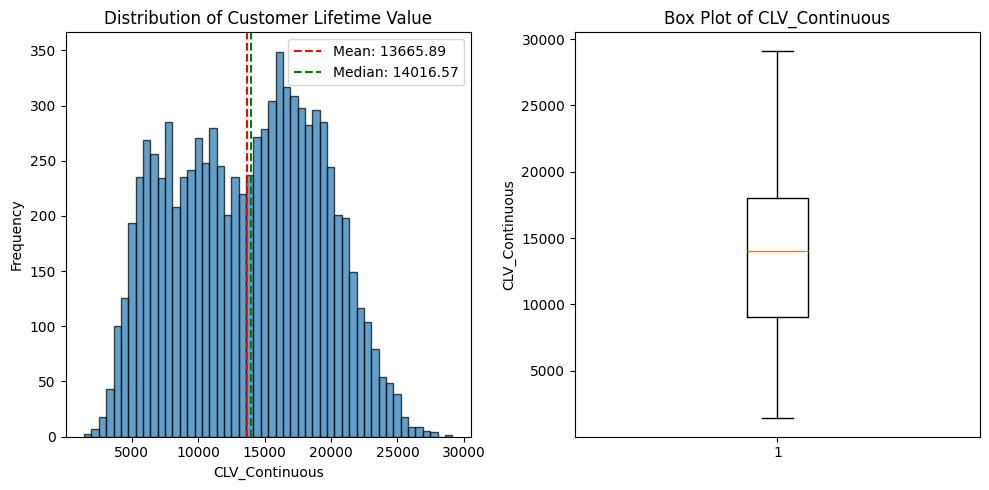

Target variable statistics:
count     8662.000
mean     13665.886
std       5443.762
min       1428.028
25%       9062.956
50%      14016.568
75%      18003.114
max      29123.503
Name: CLV_Continuous, dtype: float64


In [45]:
# Analyze the target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
axes[0].hist(FinTech["CLV_Continuous"], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('CLV_Continuous')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Customer Lifetime Value')
axes[0].axvline(FinTech["CLV_Continuous"].mean(), color='red', linestyle='--', label=f'Mean: {FinTech["CLV_Continuous"].mean():.2f}')
axes[0].axvline(FinTech["CLV_Continuous"].median(), color='green', linestyle='--', label=f'Median: {FinTech["CLV_Continuous"].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(FinTech["CLV_Continuous"], vert=True)
axes[1].set_ylabel('CLV_Continuous')
axes[1].set_title('Box Plot of CLV_Continuous')

plt.tight_layout()
plt.show()

print(f"Target variable statistics:")
print(FinTech["CLV_Continuous"].describe())

Mean ($13,666) ≈ median ($14,017) → roughly symmetric distribution. Single peak at $14k-$15k. Range: $1.4k-$29.1k, IQR: $9k-$18k. Near-normal distribution → well-suited for regression without transformations.

Preprocessing follows same steps as Assignment 1 (see that notebook for details).

In [46]:
FinTech_cleaned = FinTech.copy()

In [47]:
def clean_obj_cols(df):
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        df[col] = df[col].str.strip().str.capitalize()
    return df

FinTech_cleaned = clean_obj_cols(FinTech_cleaned)

In [48]:
geography_mapping = {
    "Fr": "France",
    "De": "Germany",
    "Es": "Spain"
}
FinTech_cleaned["CGeography"] = FinTech_cleaned["CGeography"].replace(geography_mapping)
print(f"CGeography unique values after cleaning: {FinTech_cleaned["CGeography"].unique()}")

CGeography unique values after cleaning: ['France' 'Spain' 'Germany']


In [49]:
def drop_duplicates(df):
    initial_shape = df.shape
    df = df.drop_duplicates()
    final_shape = df.shape
    print(f"Dropped {initial_shape[0] - final_shape[0]} duplicate rows.")
    return df
FinTech_cleaned = drop_duplicates(FinTech_cleaned)

Dropped 0 duplicate rows.


In [50]:
valid_ranges = {
    "CCreditScore": (0, None), "CAge": (0, 125), "CTenure": (0, None),
    "CNumOfProducts": (1, 4), "CHasCrCard": (0, 1), "CIsActiveMember": (0, 1),
    "CEstimatedSalary": (0, None), "Days_Since_Onboarding": (0, None),
    "Account_Age_Months": (0, None), "Avg_Monthly_Transactions": (0, None),
    "Transaction_Variance": (0, None), "Last_Login_Days_Ago": (0, None),
    "Support_Tickets_Count": (0, None), "Mobile_App_Usage_Hours": (0, None),
    "Onboarding_Month": (1, 12), "Is_Holiday_Onboarding": (0, 1),
    "Churn": (0, 1), "CLV_Continuous": (0, None)
}

def check_and_fix_ranges(df, ranges, fix):
    """Check for range violations and impute with median."""
    df = df.copy() if fix else df
    for col, (min_val, max_val) in ranges.items():
        if col not in df.columns:
            continue
        invalid = ((df[col] < min_val) if min_val is not None else False) | \
                  ((df[col] > max_val) if max_val is not None else False)
        n = int(invalid.sum())
        if n == 0:
            continue
        print(f"{col}: {n} violations (range: {min_val}-{max_val}, found: {df[col].min():.1f}-{df[col].max():.1f})")
        if fix:
            median = df.loc[~invalid & df[col].notna(), col].median()
            if pd.notna(median):
                df.loc[invalid, col] = median
    return df

# Check and fix violations
FinTech_cleaned = check_and_fix_ranges(FinTech_cleaned, valid_ranges, fix=True)

CAge: 11 violations (range: 0-125, found: -1.0-999.0)
CEstimatedSalary: 26 violations (range: 0-None, found: -3666.1-204659.5)


Check for inconsistent relationships between variables:

In [51]:
days_per_month = 30.44

In [52]:
def fix_constraints(df, days_per_month, tolerance_months=1):
    df = df.copy()

    # age tenure constraint
    violations = df[df['CAge'] < df['CTenure']].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            df.loc[idx, 'CTenure'] = min(df.loc[idx, 'CTenure'], df.loc[idx, 'CAge'])
        print(f"Constraint 1: {violations_count} entries corrected (CAge >= CTenure)")
    else:
        print("Constraint 1: No violations  (CAge >= CTenure)")

    # onboarding account age constraint   
    expected_months_since_onboarding = df['Days_Since_Onboarding'] / days_per_month
    discrepancy = abs(df['Account_Age_Months'] - expected_months_since_onboarding)
    
    violations = df[discrepancy > tolerance_months].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            df.loc[idx, 'Days_Since_Onboarding'] = df.loc[idx, 'Account_Age_Months'] * days_per_month
        print(f"Constraint 2: {violations_count} entries corrected (Onboarding ≈ Account_Age)")
    else:
        print("Constraint 2: No violations (Onboarding ≈ Account_Age)")

    # temporal consistency account age and last login
    account_age_days = df['Account_Age_Months'] * days_per_month
    violations = df[df['Last_Login_Days_Ago'] > account_age_days].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            account_age_in_days = df.loc[idx, 'Account_Age_Months'] * days_per_month
            df.loc[idx, 'Last_Login_Days_Ago'] = max(1, account_age_in_days - 1)
        print(f"Constraint 3: {violations_count} entries corrected (Last_Login <= Account_Age)")
    else:
        print("Constraint 3: No violations (Last_Login <= Account_Age)")

    return df

In [53]:
FinTech_cleaned =fix_constraints(FinTech_cleaned, days_per_month)

Constraint 1: No violations  (CAge >= CTenure)
Constraint 2: 40 entries corrected (Onboarding ≈ Account_Age)
Constraint 3: 322 entries corrected (Last_Login <= Account_Age)


## Data Splitting

In [54]:
# define features and target
X = FinTech_cleaned.drop(columns=["Churn", "CLV_Continuous", "Customer_ID"])
y = FinTech_cleaned["CLV_Continuous"]

from sklearn.model_selection import train_test_split
#split data 
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

Stratification is not needed in this case because y is not a binary variable but continuous.

## Check for missing values and outliers

We are going to skip the check for missing values and outliers. Please check the solution for assignment 1 for this.

In [55]:
class OutlierWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=3):
        self.multiplier = multiplier
        self.bounds_ = {}
        self.n_features_in_ = None
        self.feature_names_in_ = None
    
    def fit(self, X, y=None):
        X = np.array(X)
        for i in range(X.shape[1]):
            mean = np.nanmean(X[:, i])
            std = np.nanstd(X[:, i])
            self.bounds_[i] = (mean - self.multiplier * std, 
                               mean + self.multiplier * std)
        return self
    
    def transform(self, X):
        X = np.array(X).copy()
        for i in range(X.shape[1]):
            lower, upper = self.bounds_[i]
            X[:, i] = np.clip(X[:, i], lower, upper)
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Return feature names (passthrough since we don't change columns)."""
        if input_features is None:
            return np.array([f'x{i}' for i in range(self.n_features_in_)])
        return np.array(input_features)

## Pre-Processing Pipeline

As for the Classification Task we are going to use a pipeline that includes the following pre-processing steps:
- Handling Missing Values (Imputation)
- Handling Outliers (Winsorization)
- Feature Engineering (One-Hot-Encoding)
- Data Transformation

Linear, Polynomial, Ridge, Lasso, and Elastic Net properties (Lecture 3, slide 95):

|  | **Linear Regression** | **Polynomial Regression** | **Ridge, Lasso, Elastic Net** |
|------------|----------------------|---------------------------|--------------------------------------------------------|
| **Target function** | Linear relationship | Quadratic/higher degree | Linear/quadratic/higher degree |
| **Hyperparameters** | None (normal eq.) or ≥2 (SGD) | None (normal eq.) or ≥2 (SGD) | 1+ mixing ratio; SGD with ℓ2/ℓ1 |
| **Scaling** | Not required | Not required | Required for polynomial |

Linear regression assumptions: (1) Linearity, (2) Independence, (3) Homoscedasticity, (4) Normality of residuals, (5) No multicollinearity.

PowerTransformer (Yeo-Johnson) ensures normality for linear regression assumptions. RobustScaler standardizes data (required for polynomial Ridge/Lasso).

In [56]:
cat_transformer = Pipeline(steps=[
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

Feature Engineering: Encoding variables
We are going to use one-hot encoding for categorical variables, which are defined as follows:

In [57]:
cat_cols = ["CGeography", "CGender", "CHasCrCard" ,"CIsActiveMember", "Is_Holiday_Onboarding", "Onboarding_Month"]

Missingness <10% with no systematic pattern → median imputation preserves central tendency of skewed distributions.

In [58]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier', OutlierWinsorizer(multiplier=3)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

RobustScaler (not StandardScaler) due to outliers. PowerTransformer (Yeo-Johnson) ensures gaussian-like distributions.

In [59]:
all_numeric_cols = [col for col in X_train.columns if col not in 
                  ["Customer_ID","Churn"] + cat_cols]

Master pipeline:

In [60]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, all_numeric_cols),
    ('cat', cat_transformer, cat_cols)
],
remainder='passthrough'
)

Pipeline fit on training data, then transforms both train/test sets (prevents data leakage).

In [61]:
X_train_processed = preprocessor.fit_transform(X_train)
feature_names_train = preprocessor.get_feature_names_out()

# ensure that the test data is transformed in the same way
X_test_processed = preprocessor.transform(X_test)
feature_names_test = preprocessor.get_feature_names_out()

# convert np-array to dataframe
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_train)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_test)

In [62]:
exclude = ['Churn', 'CLV_Continuous', 'Customer_ID']
all_cols = [col for col in X_train_processed_df.columns if col not in exclude]

Distribution of the variables in X_train after preprocessing pipeline:

In [63]:
def plot_grid(df, cols, ncols=4, fig_height=2, plot_type='auto'):
    """Plot columns in a grid layout.
    plot_type: 'auto', 'hist', 'box', or 'count'
    """
    for row_start in range(0, len(cols), ncols):
        row_cols = cols[row_start:row_start + ncols]
        fig, axes = plt.subplots(1, ncols, figsize=(ncols * 2.5, fig_height))
        
        for i, col in enumerate(row_cols):
            ax = axes[i]
            data = df[col]
            
            if plot_type == 'box':
                sns.boxplot(x=data, ax=ax, color='blue', orient='h')
            elif plot_type == 'count' or (plot_type == 'auto' and data.nunique() <= 10):
                sns.countplot(x=data, ax=ax, color='blue')
                ax.tick_params(axis='x', rotation=45, labelsize=7)
            else:
                sns.histplot(x=data, ax=ax, color='blue')
                ax.tick_params(axis='x', labelsize=7)
            
            title = col.replace('num__', '').replace('cat__', '').replace('bin__', '')
            ax.set_title(title, fontsize=9)
            ax.set_xlabel('')
            ax.set_ylabel('')
        
        for i in range(len(row_cols), ncols):
            axes[i].axis('off')
        plt.subplots_adjust(wspace=0.3)
        plt.show()

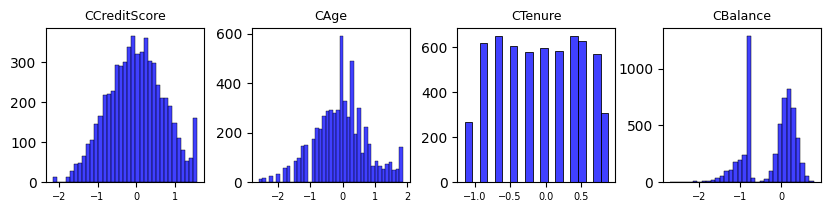

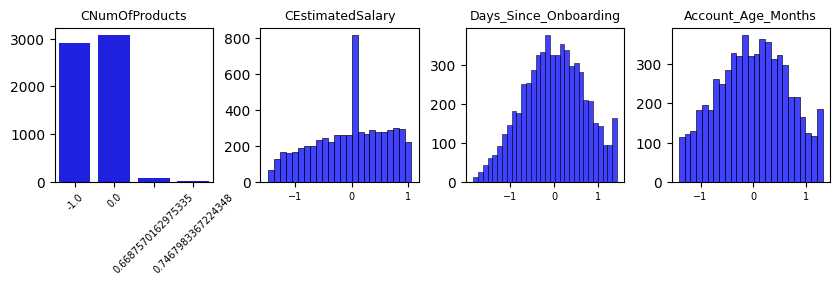

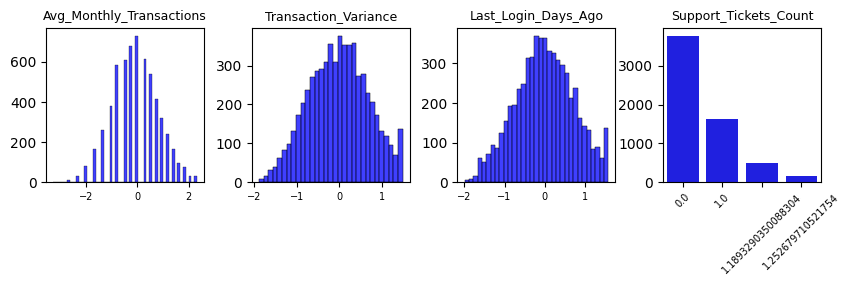

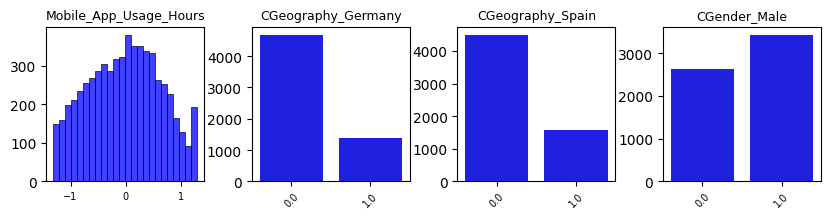

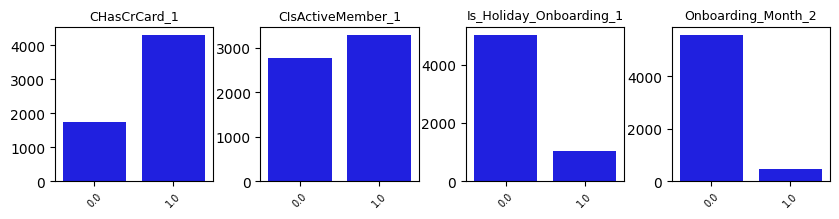

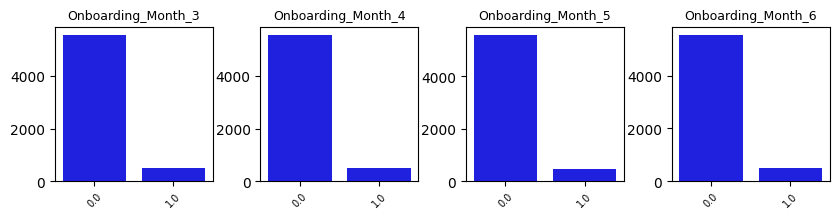

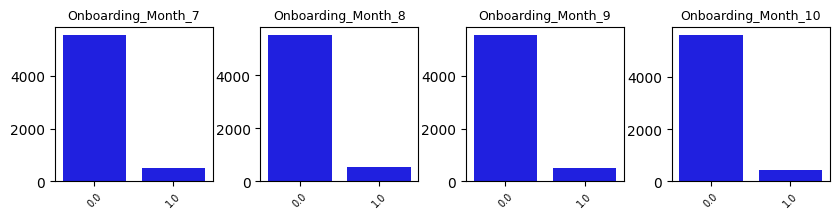

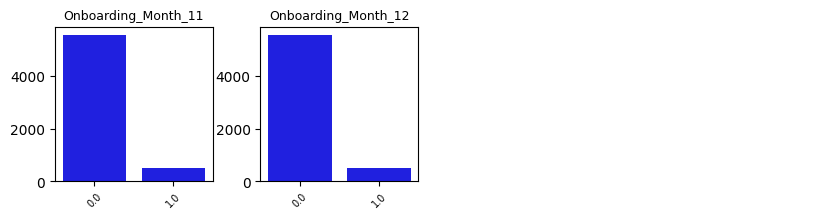

In [64]:
plot_grid(X_train_processed_df, all_cols, ncols=4, fig_height=2)

Most skewness and outliers removed via PowerTransformer. Note: For interpretation, data must be transformed back to original scale.

In [65]:
model_features = [col for col in X_train_processed_df.columns if col not in 
                  ["remainder__Customer_ID", "remainder__Churn"]]

## Check for Multicollinearity

We have to check for multicollinearity  and remove highly correlated features or apply dimensionality techniques to take this into account. To do this we are taking a look at a correlation matrix:

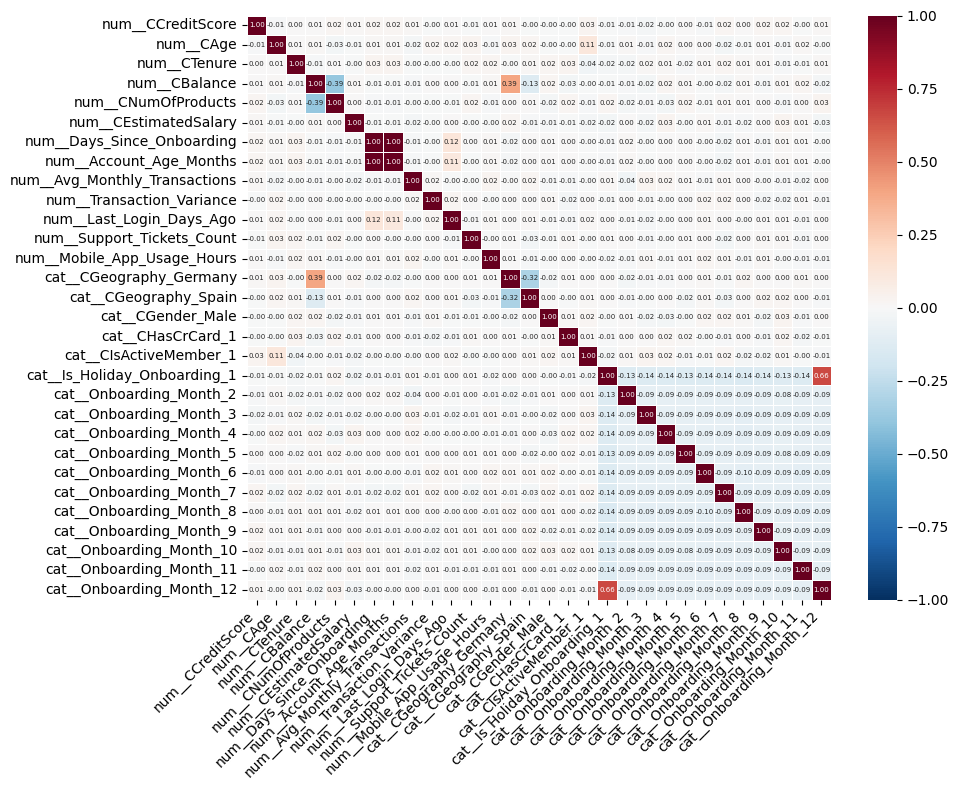

In [66]:
correlation_matrix = X_train_processed_df[model_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',              # 2 decimal places instead of many
    cmap='RdBu_r',          # Diverging colormap
    center=0,               # Center at 0
    vmin=-1, vmax=1,        # Fixed scale
    square=True,            # Square cells
    linewidths=0.5,         # Grid lines between cells
    annot_kws={'size': 5}   # Smaller font for annotations
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Also we can see a perfect positive correlation between `Days_Since_Onboarding` and `Account_Age_Months`. We are going to drop `Days_Since_Onboarding` as recommended in the task description.

In [67]:
model_features.remove('num__Days_Since_Onboarding')
X_train_processed_df = X_train_processed_df.drop(columns=['num__Days_Since_Onboarding'])
X_test_processed_df = X_test_processed_df.drop(columns=['num__Days_Since_Onboarding'])
X_train_processed = X_train_processed_df.values
X_test_processed = X_test_processed_df.values

We are going to double check now by calculating the Variance Inflation Factor (VIF) to check if there really is no significant correlation between the independant variables (features):

In [68]:
correlation_matrix = X_train_processed_df[model_features].corr()
# Identify pairs of features with high collinearity (correlation > 0.8 or < -0.8)
high_corr_features = [(col1, col2, correlation_matrix.loc[col1, col2])
                     for col1 in correlation_matrix.columns
                     for col2 in correlation_matrix.columns
                     if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8]

In [69]:
# Convert to a DataFrame for better visualization.
collinearity_df = pd.DataFrame(high_corr_features, columns=["Feature 1", "Feature 2", "Correlation"])
print("\nHighly Correlated Features:\n", collinearity_df)
# Compute Variance Inflation Factor (VIF) for each feature.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_processed_df[model_features].columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed_df[model_features].values, i) for i in range(X_train_processed_df[model_features].shape[1])]
# Display top 3 VIF values
print("Top 3 Features by VIF:")
display(vif_data.nlargest(3, "VIF"))


Highly Correlated Features:
 Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []
Top 3 Features by VIF:


,Feature,VIF
17,cat__Is_Holiday_Onboarding_1,3.390
22,cat__Onboarding_Month_6,1.786
28,cat__Onboarding_Month_12,1.774


No highly correlated features except `Days_Since_Onboarding` (removed). VIF of `cat_Is_Holiday_Onboarding`=3.39 (low/moderate correlation with `Onboarding_Month` features) is acceptable. Features sufficiently independent → proceed with modeling.

## Task 2: Train and Evaluate a Multiple Regression Model

- Build a multiple linear regression model to predict Customer Lifetime Value (regression using 
the 'CLV_Continuous' target variable)". 
- Describe your approach to building the model and interpret the performance based on 
appropriate evaluation metrics. 

Note: You are not expected to use regularization or hyperparameter tuning at this stage. 

Evaluation metrics: R² (variance explained), Adjusted R² (adjusts for feature count), RMSE, MAE. Also examine coefficients/feature importances and residual distributions.

In [70]:
# define adjusted r² function
def adjusted_r2_score(y_true, y_pred, n_features):
    """Calculate Adjusted R²"""
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adj_r2

def create_comparison_table(results, baseline_df=None, show_change=False, 
                           baseline_idx=0, compare_idx=1, highlight_best=True):
    """
    Create compact comparison table from results.
    
    Parameters:
    -----------
    results : list of dict
        Model evaluation results
    baseline_df : DataFrame, optional
        Existing results to prepend
    show_change : bool, default=False
        Add row showing % change between baseline and compared model
    baseline_idx : int, default=0
        Index of baseline model for change calculation
    compare_idx : int, default=1
        Index of model to compare against baseline
    highlight_best : bool, default=True
        Print best model summary
    
    Returns:
    --------
    df : DataFrame
        Comparison table
    """
    df = pd.DataFrame(results)
    
    # Select display columns
    display_cols = ['Model', 'Test_R2', 'Adjusted_Test_R2', 'Test_RMSE', 'Test_MAE']
    df_display = df[[col for col in display_cols if col in df.columns]].copy()
    
    # Prepend existing results if provided
    if baseline_df is not None:
        baseline_clean = baseline_df[~baseline_df['Model'].str.startswith('Δ vs')]
        df_display = pd.concat([baseline_clean, df_display], ignore_index=True)
    
    # Add relative change row if requested
    if show_change and len(df_display) > compare_idx:
        # Remove any existing change rows
        df_display = df_display[~df_display['Model'].str.startswith('Δ vs')]
        
        metric_cols = ['Test_R2', 'Adjusted_Test_R2', 'Test_RMSE', 'Test_MAE']
        baseline_name = df_display.loc[baseline_idx, 'Model']
        change_row = {'Model': f'Δ vs {baseline_name} (%)'}
        
        for col in metric_cols:
            if col in df_display.columns:
                baseline = df_display.loc[baseline_idx, col]
                compared = df_display.loc[compare_idx, col]
                change_row[col] = round((compared - baseline) / baseline * 100, 1)
        
        df_display = pd.concat([df_display, pd.DataFrame([change_row])], ignore_index=True)
    
    # Print table
    print("\n" + "="*80)
    print("Model Comparison")
    print("="*80)
    print(df_display.round(4).to_string(index=False))
    
    # Highlight best model
    if highlight_best and len(df_display) > 0:
        # Exclude change rows for best model selection
        df_models_only = df_display[~df_display['Model'].str.startswith('Δ vs')]
        if 'Test_R2' in df_models_only.columns:
            best_idx = df_models_only['Test_R2'].idxmax()
            best = df_models_only.loc[best_idx]
            print(f"\n→ Best Model: {best['Model']} (Test R²={best['Test_R2']:.4f}, RMSE={best['Test_RMSE']:.0f})")
    
    return df_display

In [71]:
def _plot_coefficients(model, feature_names, model_name):
    """Helper to plot linear model coefficients with compact output."""
    coef_values = model.coef_

    # Adjust feature names if needed
    if len(feature_names) != len(coef_values):
        feature_names = list(feature_names[:len(coef_values)]) if len(feature_names) > len(coef_values) else \
                        list(feature_names) + [f"Feature_{i}" for i in range(len(feature_names), len(coef_values))]

    df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef_values})

    # Get top features
    top_pos = df[df['Coefficient'] > 0].nlargest(3, 'Coefficient')
    top_neg = df[df['Coefficient'] < 0].nsmallest(3, 'Coefficient')

    # Compact summary (only top 3 each)
    print(f"\nTop 3 +Coef: {top_pos.iloc[0]['Feature']} ({top_pos.iloc[0]['Coefficient']:.2f}), "
          f"{top_pos.iloc[1]['Feature']} ({top_pos.iloc[1]['Coefficient']:.2f}), "
          f"{top_pos.iloc[2]['Feature']} ({top_pos.iloc[2]['Coefficient']:.2f})")
    print(f"Top 3 -Coef: {top_neg.iloc[0]['Feature']} ({top_neg.iloc[0]['Coefficient']:.2f}), "
          f"{top_neg.iloc[1]['Feature']} ({top_neg.iloc[1]['Coefficient']:.2f}), "
          f"{top_neg.iloc[2]['Feature']} ({top_neg.iloc[2]['Coefficient']:.2f})")

    # Plot top 5 positive and top 5 negative
    top_pos_plot = df[df['Coefficient'] > 0].nlargest(5, 'Coefficient')
    top_neg_plot = df[df['Coefficient'] < 0].nsmallest(5, 'Coefficient')
    plot_df = pd.concat([top_pos_plot, top_neg_plot]).sort_values('Coefficient', key=abs, ascending=False)

    fig, ax = plt.subplots(figsize=(7, 5))
    colors = ['green' if x > 0 else 'red' for x in plot_df['Coefficient']]
    ax.barh(range(len(plot_df)), plot_df['Coefficient'], color=colors, alpha=0.7)

    # Add labels
    for i, (_, row) in enumerate(plot_df.iterrows()):
        value = row['Coefficient']
        ha = 'left' if value >= 0 else 'right'
        x_pos = value + (0.02 * plot_df['Coefficient'].abs().max() * (1 if value >= 0 else -1))
        ax.text(x_pos, i, f'{value:.2f}', va='center', ha=ha, fontsize=9, fontweight='bold')

    # FIX: Adjust x-axis limits to prevent label collision (more space on left for negative labels)
    max_abs_coef = plot_df['Coefficient'].abs().max()
    ax.set_xlim(-max_abs_coef * 1.35, max_abs_coef * 1.1)  # 35% extra space on left, 10% on right

    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df['Feature'])
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'{model_name}: Top Coefficients')
    ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


def _plot_importances(model, feature_names, model_name, plot_top_n=10):
    """Helper to plot tree model feature importances with compact output."""
    imp_values = model.feature_importances_

    # Adjust feature names if needed
    if len(feature_names) != len(imp_values):
        feature_names = list(feature_names[:len(imp_values)]) if len(feature_names) > len(imp_values) else \
                        list(feature_names) + [f"Feature_{i}" for i in range(len(feature_names), len(imp_values))]

    df = pd.DataFrame({'Feature': feature_names, 'Importance': imp_values}).sort_values('Importance', ascending=False)

    # Compact summary (only top 3)
    print(f"\nTop 3 Features: {df.iloc[0]['Feature']} ({df.iloc[0]['Importance']:.4f}), "
          f"{df.iloc[1]['Feature']} ({df.iloc[1]['Importance']:.4f}), "
          f"{df.iloc[2]['Feature']} ({df.iloc[2]['Importance']:.4f})")

    # Plot top N
    plot_df = df.head(plot_top_n)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(plot_df)), plot_df['Importance'], color='steelblue', alpha=0.7)

    for i, (_, row) in enumerate(plot_df.iterrows()):
        value = row['Importance']
        x_pos = value + (0.01 * plot_df['Importance'].max())
        ax.text(x_pos, i, f'{value:.4f}', va='center', ha='left', fontsize=9, fontweight='bold')

    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df['Feature'])
    ax.set_xlabel('Importance')
    ax.set_title(f'{model_name}: Top {plot_top_n} Features')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model",
                   feature_names=None, plot_top_n=10):
    """
    Evaluate regression model and return metrics with visualizations.

    Parameters:
    -----------
    model : estimator object
        Trained model (LinearRegression, Ridge, DecisionTree, ensemble models, etc.)
    X_train, X_test : array-like
        Training and test feature sets
    y_train, y_test : array-like
        Training and test target values
    model_name : str
        Name of the model for display purposes
    feature_names : list, optional
        Names of features for coefficient/importance plots
    plot_top_n : int, default=10
        Number of top features to display in importance plot

    Returns:
    --------
    metrics : dict
        Dictionary containing performance metrics
    y_test_pred : array-like
        Test set predictions
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    n_train, p = X_train.shape
    n_test = X_test.shape[0]

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Adjusted R² with validity check
    adjusted_train_r2 = adjusted_r2_score(y_train, y_train_pred, p) if n_train - p - 1 > 0 else np.nan
    adjusted_test_r2 = adjusted_r2_score(y_test, y_test_pred, p) if n_test - p - 1 > 0 else np.nan

    metrics = {
        'Model': model_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Adjusted_Train_R2': adjusted_train_r2,
        'Adjusted_Test_R2': adjusted_test_r2,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    }

    print(f"\n{model_name}")
    print(f"Train: R²={metrics['Train_R2']:.4f}, Adj R²={metrics['Adjusted_Train_R2']:.4f}, "
          f"RMSE={metrics['Train_RMSE']:.0f}, MAE={metrics['Train_MAE']:.0f}")
    print(f"Test:  R²={metrics['Test_R2']:.4f}, Adj R²={metrics['Adjusted_Test_R2']:.4f}, "
          f"RMSE={metrics['Test_RMSE']:.0f}, MAE={metrics['Test_MAE']:.0f}")

    # Feature importance/coefficients (using helper functions)
    if feature_names is not None:
        if hasattr(model, 'coef_'):
            _plot_coefficients(model, feature_names, model_name)
        elif hasattr(model, 'feature_importances_'):
            _plot_importances(model, feature_names, model_name, plot_top_n)

    # Residuals plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot 1: Regression Fit
    axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual CLV')
    axes[0].set_ylabel('Predicted CLV')
    axes[0].set_title(f'{model_name}: Predicted vs Actual')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Residuals Distribution
    residuals = y_test - y_test_pred
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    axes[1].set_xlabel('Residuals (Actual - Predicted)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name}: Residual Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return metrics, y_test_pred


Multiple Linear Regression
Train: R²=0.8983, Adj R²=0.8978, RMSE=1731, MAE=1203
Test:  R²=0.9018, Adj R²=0.9007, RMSE=1717, MAE=1185

Top 3 +Coef: num__CBalance (8075.84), num__CEstimatedSalary (3379.57), cat__CIsActiveMember_1 (1242.90)
Top 3 -Coef: num__CAge (-135.02), num__Last_Login_Days_Ago (-92.00), cat__Onboarding_Month_4 (-87.94)


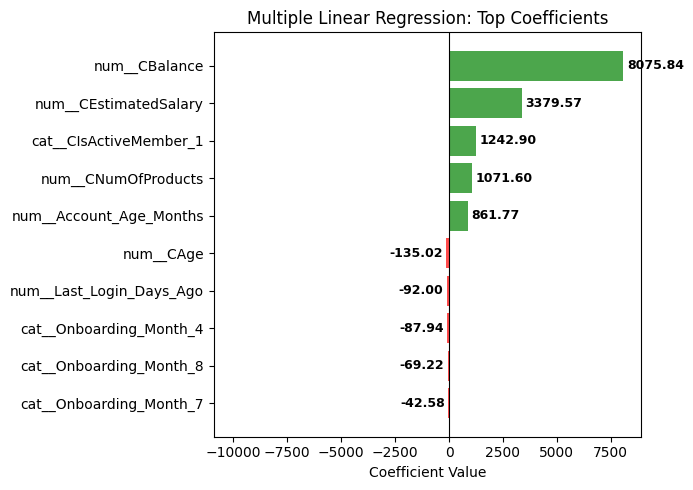

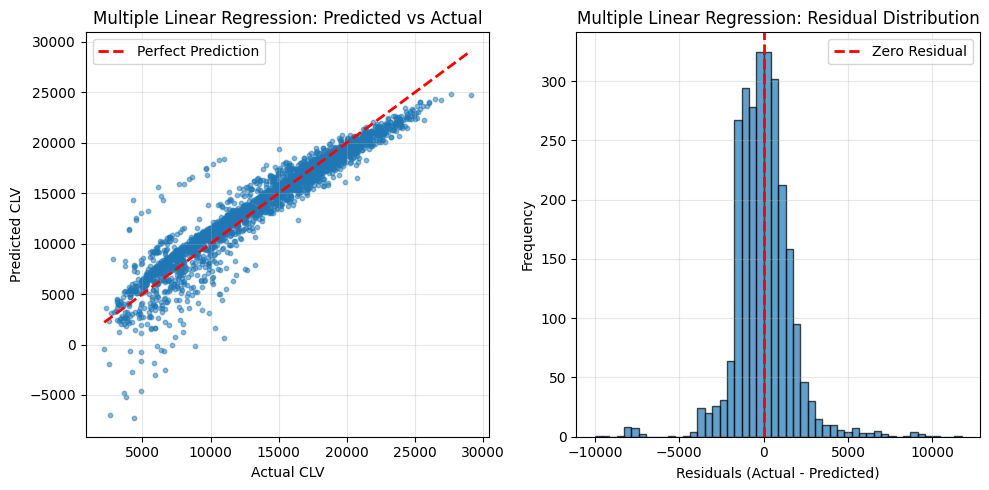

In [72]:
# Train Multiple Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)

# Evaluate the model
lr_metrics, lr_pred = evaluate_model(
    lr_model, 
    X_train_processed, 
    X_test_processed, 
    y_train, 
    y_test, 
    model_name = "Multiple Linear Regression", 
    feature_names = X_train_processed_df.columns
)

### Interpretation

**Performance:** Adj R²=0.90 (train/test similar → no overfitting), RMSE=1,717, MAE=1,185. Model explains 90% of CLV variance.

**Top Predictors:** CBalance (+8,076), CEstimatedSalary (+3,380), CIsActiveMember (+1,243), CNumOfProducts (+1,072). Negative: CAge (-135), Last_Login_Days_Ago (-92).

**Issues:** Some predictions go negative (dataset has no negative CLV). Scatter widens at low CLV values. Cluster at low actual CLV (2000-5000) predicted near zero. Residuals centered at zero (no systematic bias), roughly bell-shaped, but with heavy tails and slight right skew.

## Task 3: Polynomial Regression Models

- Train and evaluate at least two polynomial regression models with different polynomial 
degrees. 
- Compare the results of the polynomial regression models with the linear regression model 
from Task 2. Discuss how the model's performance changes as the degree of the polynomial 
increases.

Polynomial regression extends linear regression by adding polynomial terms to capture non-linear feature relationships.


Training Polynomial Regression (degree=2)
Features after polynomial transformation: 464

Polynomial Regression (degree=2)
Train: R²=0.9692, Adj R²=0.9666, RMSE=953, MAE=586
Test:  R²=0.9671, Adj R²=0.9599, RMSE=995, MAE=620

Top 3 +Coef: num__CBalance (10712.46), num__CBalance^2 (4317.46), num__CEstimatedSalary (3312.46)
Top 3 -Coef: num__CBalance cat__CGeography_Germany (-617.40), cat__CGeography_Spain cat__Onboarding_Month_5 (-258.62), cat__CGeography_Germany cat__Onboarding_Month_12 (-256.11)


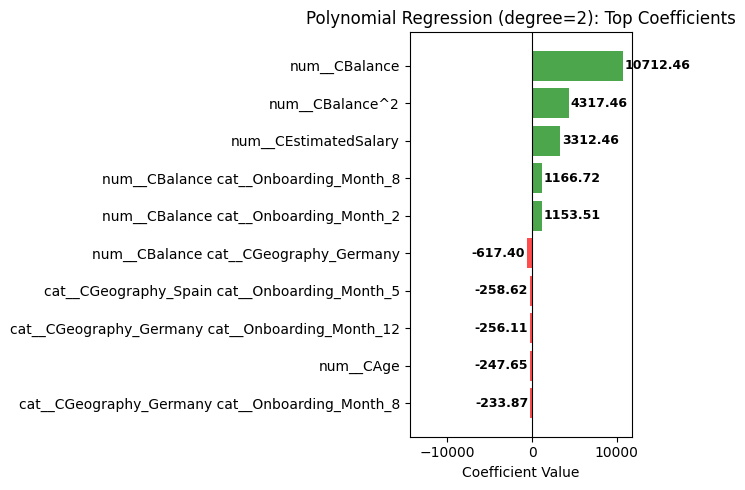

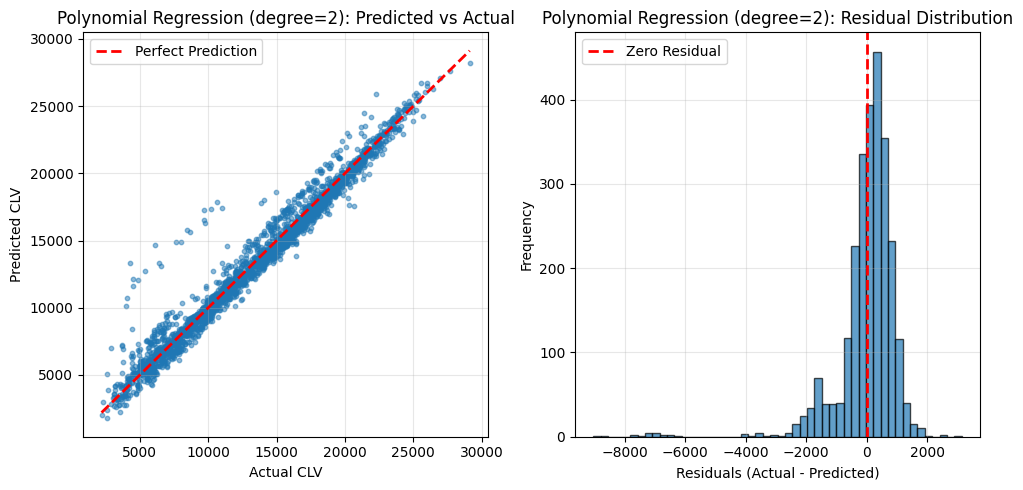


Training Polynomial Regression (degree=3)
Features after polynomial transformation: 4959

Polynomial Regression (degree=3)
Train: R²=0.9841, Adj R²=0.9125, RMSE=685, MAE=486
Test:  R²=0.9394, Adj R²=nan, RMSE=1350, MAE=952

Top 3 +Coef: num__CNumOfProducts^3 (16570.02), num__CBalance (10357.13), num__CNumOfProducts^2 (5068.79)
Top 3 -Coef: num__CNumOfProducts (-8629.44), num__Support_Tickets_Count^2 (-8511.66), num__CBalance^2 cat__CGeography_Germany (-3651.51)


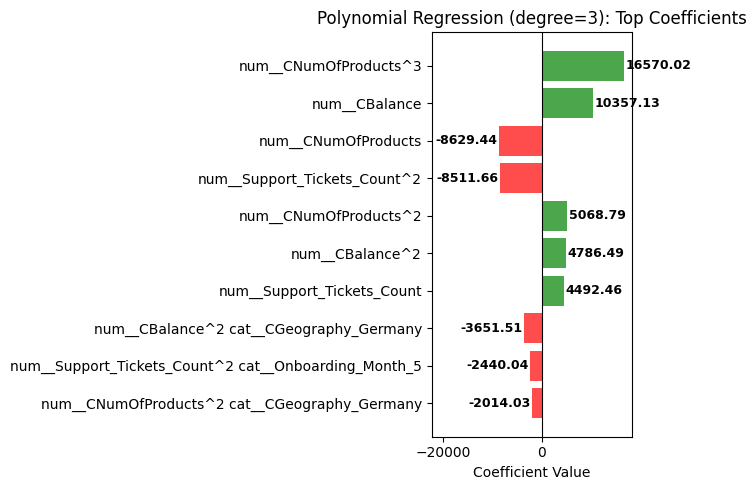

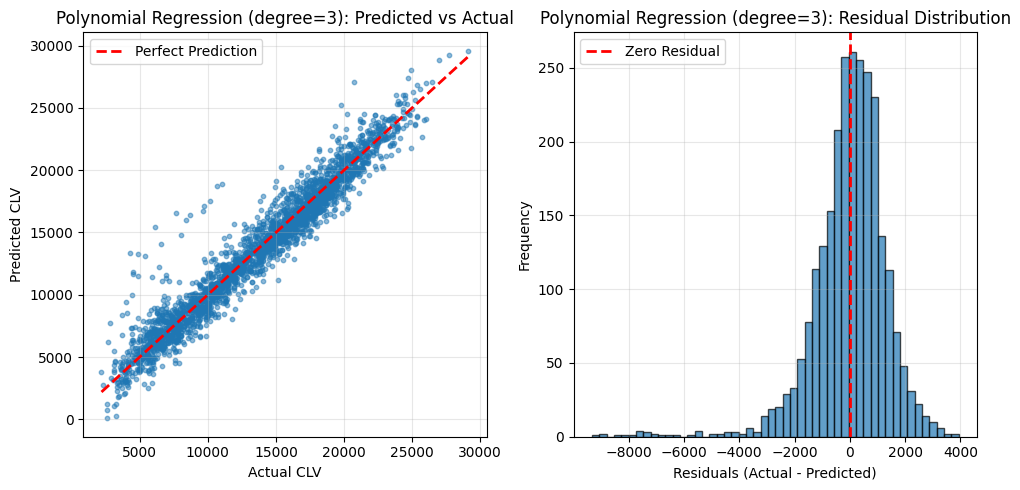

In [73]:
# Train polynomial regression models with different degrees
poly_results = []

for degree in [2, 3]:
    print(f"\n{'='*60}")
    print(f"Training Polynomial Regression (degree={degree})")
    print(f"{'='*60}")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_processed)
    X_test_poly = poly.transform(X_test_processed)
    
    print(f"Features after polynomial transformation: {X_train_poly.shape[1]}")
    
    # Train model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    # Evaluate
    metrics, pred = evaluate_model(
        poly_model, 
        X_train_poly, 
        X_test_poly,
        y_train, 
        y_test, 
        model_name = f"Polynomial Regression (degree={degree})",
        feature_names = poly.get_feature_names_out(X_train_processed_df.columns)

    )
    
    poly_results.append({
        'degree': degree,
        'model': poly_model,
        'poly_transformer': poly,
        'metrics': metrics,
        'predictions': pred
    })

Adjusted R² not calculable for degree=3 (features > test samples).

### Interpretation

**Polynomial Degree 2:** Adj R²=0.96 (train/test), RMSE=995, MAE=619. Captures non-linear relationships well. CBalance and CEstimatedSalary remain strongest predictors. Shows seasonal influence (CBalance × Onboarding_Month interactions). Cluster of overpredictions (actual 5k-10k → predicted 10k-17k) suggests subgroup with high-value characteristics but lower actual CLV. Residuals centered, mostly symmetric, slight left skew.

**Polynomial Degree 3:** R²=0.984 (train) vs 0.939 (test) → 4.5% gap indicates overfitting. RMSE=1,350, MAE=952 (worse than degree=2). Good fit for mid-range CLV, scatter at extremes. Wider residual spread, heavier left tail → less stable predictions.

## Task 4: Model Comparison

- Compare the performance of the multiple linear regression model from Task 2 and the 
polynomial regression models from Task 3. 
- Discuss which model performs better and provide a rationale for your conclusions. 
Note: Regularization and hyperparameter tuning are not required at this point. 

Higher polynomial degrees typically improve training performance but may degrade test performance due to overfitting (model captures training regularities but fails to generalize).

In [74]:
# Compare polynomial models
comparison_data = [lr_metrics] + [r['metrics'] for r in poly_results]
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df[['Model', 'Train_R2', 'Test_R2', 'Adjusted_Train_R2', 'Adjusted_Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']]

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
                           Model  Train_R2  Test_R2  Adjusted_Train_R2  Adjusted_Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE
      Multiple Linear Regression     0.898    0.902              0.898             0.901    1730.807   1716.943   1202.982  1184.807
Polynomial Regression (degree=2)     0.969    0.967              0.967             0.960     952.977    994.599    586.115   619.845
Polynomial Regression (degree=3)     0.984    0.939              0.913               NaN     684.746   1349.523    486.302   951.913


### Conclusion

Polynomial degree=2 outperforms linear regression (Adj R²: 0.96 vs 0.90) and degree=3 model (which overfits with 4.5% train-test gap). Degree=2 captures non-linear relationships without overfitting → selected for following tasks.

## Task 5: Regularization and Optimization

- Optimize your results by applying regularization techniques, such as Ridge or Lasso 
regression (Note: select the best-performing model in Task 4). 
- Use cross-validation and hyperparameter tuning (e.g., GridSearchCV or 
RandomizedSearchCV) to further optimize your model's performance. 
- Explain whether your model is overfitting or underfitting, and interpret the results using 
evaluation metrics and visualizations.

We apply Elastic Net regularization to the best-performing model (degree=2 polynomial). Elastic Net combines Ridge (shrinks coefficients) and Lasso (feature selection via coefficient zeroing). The l1_ratio parameter controls the mix: 0=Ridge, 1=Lasso, 0.5=equal mix.


Elastic Net Regression - Polynomial Degree 2 (Default Parameters)
Features after polynomial transformation: 464

Elastic Net Poly-2 (Default: alpha=1.0, l1_ratio=0.5)
Train: R²=0.7600, Adj R²=0.7401, RMSE=2659, MAE=2122
Test:  R²=0.7534, Adj R²=0.6998, RMSE=2721, MAE=2179


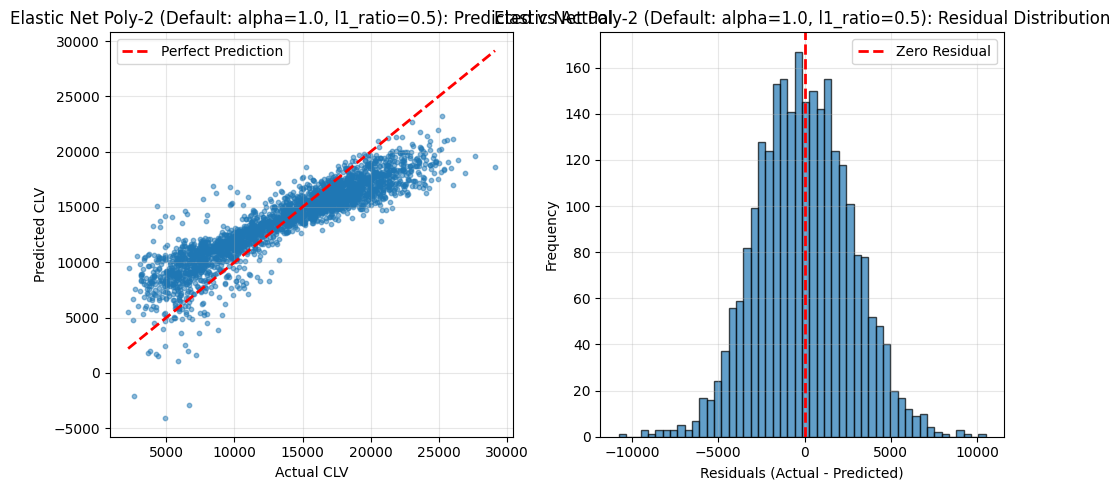

In [75]:
# save results
advanced_model_results = []

# Elastic Net Regression with existing Polynomial Degree 2 - Default Parameters
print("\n" + "="*60)
print("Elastic Net Regression - Polynomial Degree 2 (Default Parameters)")
print("="*60)

# Reuse the polynomial transformer from Task 3
poly_2_transformer = poly_results[0]['poly_transformer']  # degree=2 is first in list
X_train_poly_2 = poly_2_transformer.transform(X_train_processed)
X_test_poly_2 = poly_2_transformer.transform(X_test_processed)

print(f"Features after polynomial transformation: {X_train_poly_2.shape[1]}")

# Initialize Elastic Net with default parameters
elastic_net_poly2_default = ElasticNet(random_state=42, max_iter=10000)

# Fit the model
elastic_net_poly2_default.fit(X_train_poly_2, y_train)

# Evaluate the model
elastic_net_poly2_default_metrics, elastic_net_poly2_default_pred = evaluate_model(
    elastic_net_poly2_default, X_train_poly_2, X_test_poly_2,
    y_train, y_test, "Elastic Net Poly-2 (Default: alpha=1.0, l1_ratio=0.5)"
)

advanced_model_results.append(elastic_net_poly2_default_metrics)


### Interpretation: Default Elastic Net (alpha=1.0)

Moderate fit: Adj R²=0.70, RMSE=2,721, MAE=2,178. High alpha (strong regularization) limits model performance. Wide scatter, negative predictions. High prediction uncertainty.

Optimize model with GridSearchCV (hyperparameter tuning + cross-validation):


Elastic Net Regression - Polynomial Degree 2 with Cross-Validation
Features after polynomial transformation: 464
Best alpha: 0.001
Best l1_ratio: 0.5
Best CV R2: 0.9421

Elastic Net Poly-2 (alpha=0.001, l1_ratio=0.5)
Train: R²=0.9691, Adj R²=0.9665, RMSE=954, MAE=589
Test:  R²=0.9671, Adj R²=0.9600, RMSE=994, MAE=622


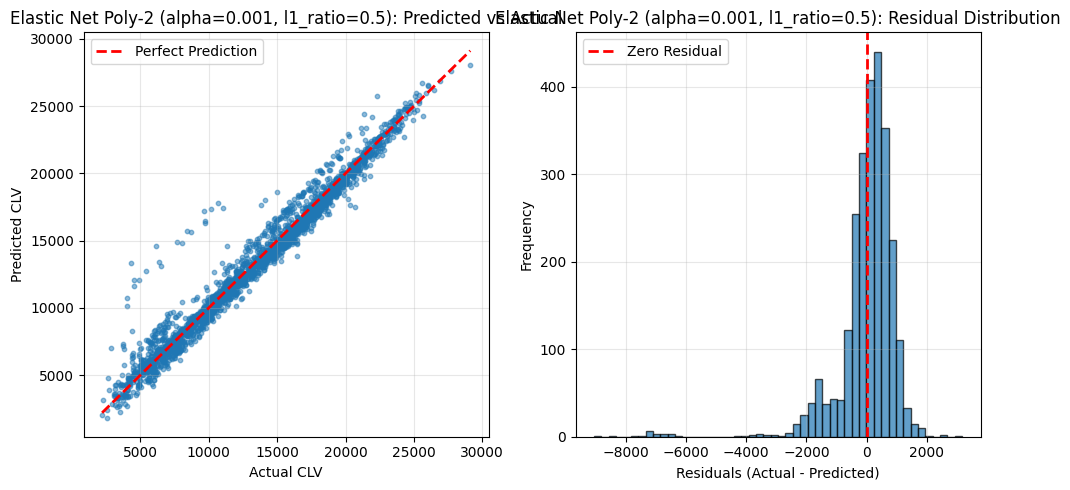

In [76]:
# Elastic Net Regression with existing Polynomial Degree 2 and GridSearchCV
print("\n" + "="*60)
print("Elastic Net Regression - Polynomial Degree 2 with Cross-Validation")
print("="*60)
print(f"Features after polynomial transformation: {X_train_poly_2.shape[1]}")

elastic_net_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # 0=Ridge, 1=Lasso, 0.5=equal mix
}

n_features = X_train_poly_2.shape[1]
adjusted_r2_scorer = make_scorer(
    lambda y_true, y_pred: adjusted_r2_score(y_true, y_pred, n_features),
    greater_is_better=True
)

elastic_net_poly2_grid = GridSearchCV(
    ElasticNet(random_state=42, max_iter=10000),
    elastic_net_params,
    cv=5,
    scoring=adjusted_r2_scorer,
    return_train_score=True,
    n_jobs=-1
)

elastic_net_poly2_grid.fit(X_train_poly_2, y_train)

print(f"Best alpha: {elastic_net_poly2_grid.best_params_['alpha']}")
print(f"Best l1_ratio: {elastic_net_poly2_grid.best_params_['l1_ratio']}")
print(f"Best CV R2: {elastic_net_poly2_grid.best_score_:.4f}")

# Evaluate best Elastic Net model
elastic_net_poly2_metrics, elastic_net_poly2_pred = evaluate_model(
    elastic_net_poly2_grid.best_estimator_, X_train_poly_2, X_test_poly_2,
    y_train, y_test, 
    f"Elastic Net Poly-2 (alpha={elastic_net_poly2_grid.best_params_['alpha']}, l1_ratio={elastic_net_poly2_grid.best_params_['l1_ratio']})"
)

advanced_model_results.append(elastic_net_poly2_metrics)

### Interpretation: Tuned Elastic Net (alpha=0.001)

Excellent fit: Adj R²=0.96 (train/test), RMSE=994, MAE=622. Minimal overfitting (0.002 gap). Low alpha allows model to use polynomial features effectively. Same overprediction cluster (5k-10k actual → 10k-17k predicted). Residuals centered at zero, slight left skew.

Tuned model outperforms default (low alpha=0.001 allows better use of polynomial features). Learning curves confirm minimal overfitting.

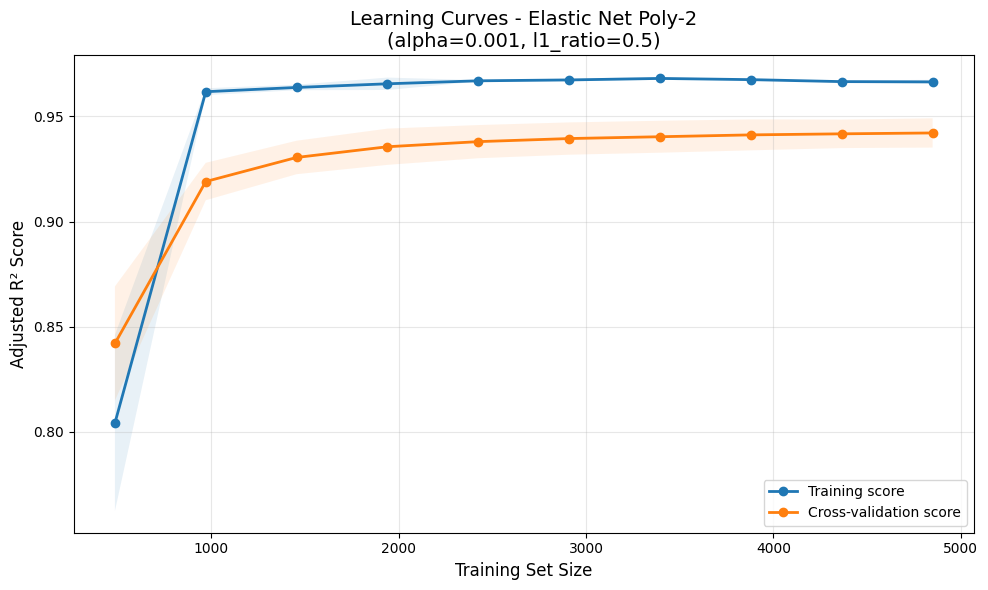

Final training score: 0.9665 (+/- 0.0010)
Final validation score: 0.9422 (+/- 0.0070)
Training-Validation gap: 0.0243


In [77]:
# Generate learning curves for the best Elastic Net model

train_sizes, train_scores, val_scores = learning_curve(
    elastic_net_poly2_grid.best_estimator_,
    X_train_poly_2, 
    y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points from 10% to 100% of data
    scoring=adjusted_r2_scorer,
    random_state=42
)

# Calculate mean and std for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score', linewidth=2)
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1)

plt.plot(train_sizes, val_scores_mean, 'o-', label='Cross-validation score', linewidth=2)
plt.fill_between(train_sizes, 
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, 
                 alpha=0.1)

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Adjusted R² Score', fontsize=12)
plt.title(f'Learning Curves - Elastic Net Poly-2\n(alpha={elastic_net_poly2_grid.best_params_["alpha"]}, l1_ratio={elastic_net_poly2_grid.best_params_["l1_ratio"]})', 
          fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some insights
print(f"Final training score: {train_scores_mean[-1]:.4f} (+/- {train_scores_std[-1]:.4f})")
print(f"Final validation score: {val_scores_mean[-1]:.4f} (+/- {val_scores_std[-1]:.4f})")
print(f"Training-Validation gap: {train_scores_mean[-1] - val_scores_mean[-1]:.4f}")


**Learning Curves:** Plateau at ~1,000 samples. Parallel lines above 1,000 samples → consistent generalization. Small train-validation gap (0.02) → minimal overfitting. Sufficient training data.

## Task 6: Regression Tree Model

- Train and evaluate a regression tree model to predict Customer Lifetime Value (regression 
using the 'CLV_Continuous' target variable). 
- use hyperparameter tuning and cross-validation to optimize the regression tree model. 
- Analyze and explain whether your model is overfitting or underfitting, and interpret the 
results with appropriate metrics and plots.

Regression Trees capture non-linear relationships and feature interactions without explicit polynomial terms.


Decision Tree Regressor - Baseline (Default Parameters)
Default max_depth: None
Default min_samples_split: 2
Default min_samples_leaf: 1
Actual tree depth: 30
Number of leaves: 6044

Decision Tree (Default Parameters)
Train: R²=1.0000, Adj R²=1.0000, RMSE=0, MAE=0
Test:  R²=0.9671, Adj R²=0.9668, RMSE=993, MAE=695


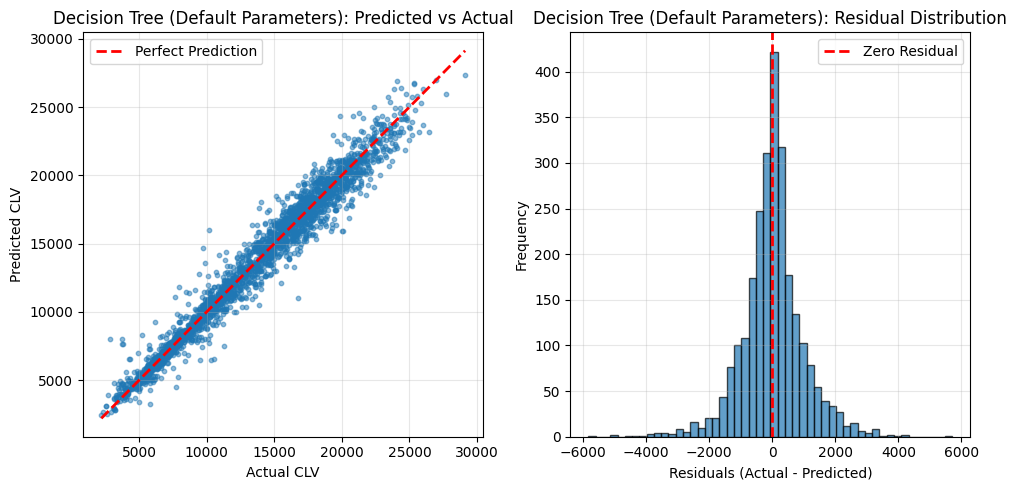

In [78]:
# Decision Tree Regressor - Baseline (Default Parameters)
print("\n" + "="*60)
print("Decision Tree Regressor - Baseline (Default Parameters)")
print("="*60)

# Create and train baseline decision tree with default parameters
tree_baseline = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_baseline.fit(X_train_processed, y_train)

print(f"Default max_depth: {tree_baseline.max_depth}")
print(f"Default min_samples_split: {tree_baseline.min_samples_split}")
print(f"Default min_samples_leaf: {tree_baseline.min_samples_leaf}")
print(f"Actual tree depth: {tree_baseline.get_depth()}")
print(f"Number of leaves: {tree_baseline.get_n_leaves()}")

# Evaluate baseline model
tree_baseline_metrics, tree_baseline_pred = evaluate_model(
    tree_baseline, X_train_processed, X_test_processed,
    y_train, y_test,
    "Decision Tree (Default Parameters)"
)

advanced_model_results.append(tree_baseline_metrics)

### Interpretation: Baseline Decision Tree

**Perfect training fit:** Train R²=1.0, RMSE=0, MAE=0 (memorizes training data). **Test performance:** R²=0.967, RMSE=993, MAE=695. Train-test gap of 3.3% indicates overfitting. Tree depth and leaves unrestricted → captures noise.


Decision Tree Regressor with Cross-Validation
Best parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best CV R²: 0.9646
Actual tree depth: 15
Number of leaves: 511

Decision Tree (max_depth=15, min_samples_split=20, min_samples_leaf=5)
Train: R²=0.9859, Adj R²=0.9858, RMSE=644, MAE=460
Test:  R²=0.9686, Adj R²=0.9682, RMSE=972, MAE=692


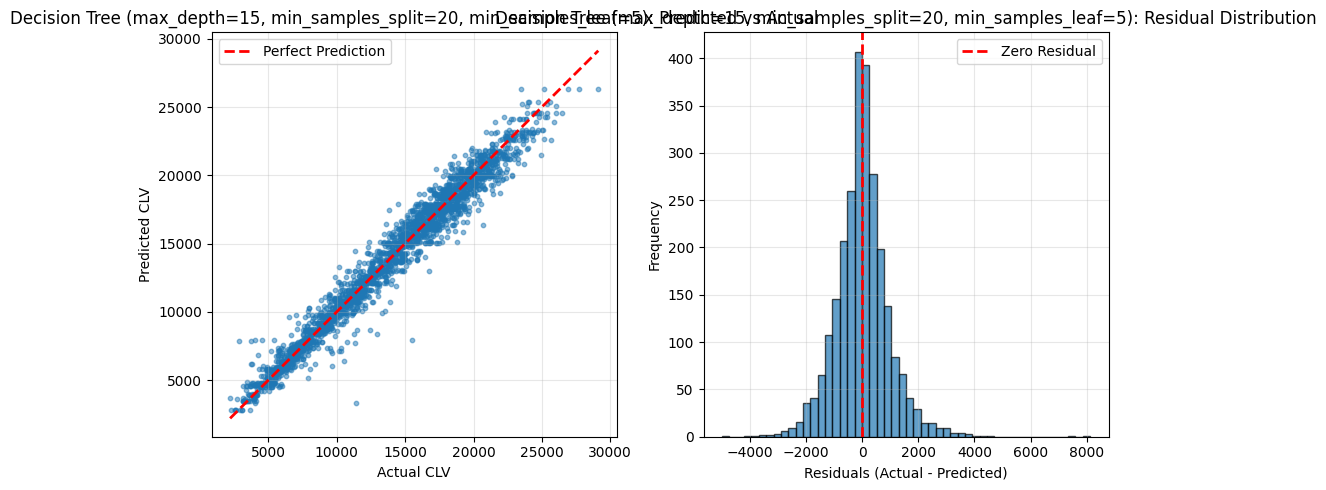

In [79]:
# Decision Tree Regressor with GridSearchCV
print("\n" + "="*60)
print("Decision Tree Regressor with Cross-Validation")
print("="*60)

# Create adjusted R² scorer for Decision Tree features
n_features_tree = X_train_processed.shape[1]
adjusted_r2_scorer_tree = make_scorer(
    lambda y_true, y_pred: adjusted_r2_score(y_true, y_pred, n_features_tree),
    greater_is_better=True
)

tree_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

tree_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    tree_params,
    cv=5,
    scoring=adjusted_r2_scorer_tree,
    return_train_score=True,
    n_jobs=-1
)

tree_grid.fit(X_train_processed, y_train)

print(f"Best parameters: {tree_grid.best_params_}")
print(f"Best CV R²: {tree_grid.best_score_:.4f}")
print(f"Actual tree depth: {tree_grid.best_estimator_.get_depth()}")
print(f"Number of leaves: {tree_grid.best_estimator_.get_n_leaves()}")

# Evaluate best Decision Tree model
tree_tuned_metrics, tree_tuned_pred = evaluate_model(
    tree_grid.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test,
    f"Decision Tree (max_depth={tree_grid.best_params_['max_depth']}, min_samples_split={tree_grid.best_params_['min_samples_split']}, min_samples_leaf={tree_grid.best_params_['min_samples_leaf']})"
)

advanced_model_results.append(tree_tuned_metrics)

### Interpretation: Tuned Decision Tree

**Improved:** Train R²=0.986, Test R²=0.969, RMSE=972, MAE=692. Train-test gap reduced to 1.7% (less overfitting). Best params: max_depth=15, min_samples_split=20, min_samples_leaf=5. Constraints prevent overfitting while maintaining good performance.

## Task 7: Model Comparison

- Compare the performance of the machine learning model optimized in Task 5 and the 
regression tree model from Task 6. 
- Discuss which model performs better. Also explain why the model performs better. Use 
metrics and reasoning based on the strengths and weaknesses of each model. 

In [80]:
advanced_comparison = pd.DataFrame(advanced_model_results)

print("\n" + "="*80)
print("TASK 7: MODEL COMPARISON - Elastic Net vs Regression Tree")
print("="*80)
print("\nModel Comparison:")
print(advanced_comparison[['Model', 'Train_R2', 'Test_R2', 'Adjusted_Train_R2', 'Adjusted_Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']].to_string(index=False))



TASK 7: MODEL COMPARISON - Elastic Net vs Regression Tree

Model Comparison:
                                                                 Model  Train_R2  Test_R2  Adjusted_Train_R2  Adjusted_Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE
                 Elastic Net Poly-2 (Default: alpha=1.0, l1_ratio=0.5)     0.760    0.753              0.740             0.700    2659.035   2721.376   2122.489  2178.729
                        Elastic Net Poly-2 (alpha=0.001, l1_ratio=0.5)     0.969    0.967              0.967             0.960     953.936    993.851    588.813   621.728
                                    Decision Tree (Default Parameters)     1.000    0.967              1.000             0.967       0.000    993.441      0.000   694.994
Decision Tree (max_depth=15, min_samples_split=20, min_samples_leaf=5)     0.986    0.969              0.986             0.968     644.422    971.518    460.328   691.512


### Interpretation

**Tuned Decision Tree** slightly outperforms **Tuned Elastic Net Poly-2**: Test R²=0.969 vs 0.967, RMSE=972 vs 994. Decision Tree achieves this without polynomial feature expansion (28 features vs 433). Both show minimal overfitting (gaps <2%). Decision Tree advantages: simpler feature space, comparable performance, lower MAE. Elastic Net advantage: more stable predictions across feature range.

## Task 8: Ensemble Learning

- Use an ensemble learning technique to improve your model's performance. Compare the 
results with the model you selected from Task 7. 
- Use hyperparameter tuning and cross-validation to optimize your ensemble model. 
- Analyze whether your ensemble model is overfitting or underfitting, and explain the results 
based on your evaluation. 

Ensemble method: **Random Forest** (combines multiple decision trees via bagging)


Random Forest Regressor - Baseline (Default Parameters)
Default n_estimators: 100
Default max_depth: None
Default min_samples_split: 2
Default min_samples_leaf: 1

Random Forest (Default Parameters)
Train: R²=0.9978, Adj R²=0.9978, RMSE=255, MAE=171
Test:  R²=0.9850, Adj R²=0.9848, RMSE=672, MAE=464


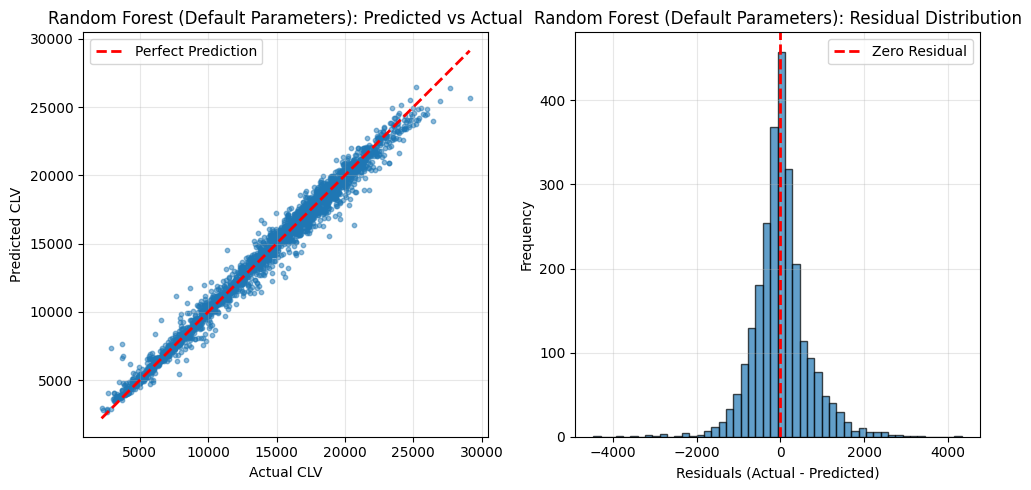

In [81]:
# Random Forest Regressor - Baseline (Default Parameters)
print("\n" + "="*60)
print("Random Forest Regressor - Baseline (Default Parameters)")
print("="*60)

# Create and train baseline Random Forest with default parameters
rf_baseline = RandomForestRegressor(random_state=RANDOM_STATE)
rf_baseline.fit(X_train_processed, y_train)

print(f"Default n_estimators: {rf_baseline.n_estimators}")
print(f"Default max_depth: {rf_baseline.max_depth}")
print(f"Default min_samples_split: {rf_baseline.min_samples_split}")
print(f"Default min_samples_leaf: {rf_baseline.min_samples_leaf}")

# Evaluate baseline model
rf_baseline_metrics, rf_baseline_pred = evaluate_model(
    rf_baseline, X_train_processed, X_test_processed,
    y_train, y_test,
    "Random Forest (Default Parameters)"
)

advanced_model_results.append(rf_baseline_metrics)

### Interpretation: Baseline Random Forest

**Strong performance with defaults:** Train R²=0.998, Test R²=0.985, RMSE=672, MAE=464. Train-test gap=1.3% (minimal overfitting). Already outperforms all previous models. Default params (100 estimators, unlimited depth) provide excellent baseline.


Random Forest Regressor with Cross-Validation
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}
Best CV Adjusted R²: 0.9824

Random Forest (n_estimators=200, max_depth=15)
Train: R²=0.9978, Adj R²=0.9978, RMSE=253, MAE=173
Test:  R²=0.9851, Adj R²=0.9850, RMSE=668, MAE=462


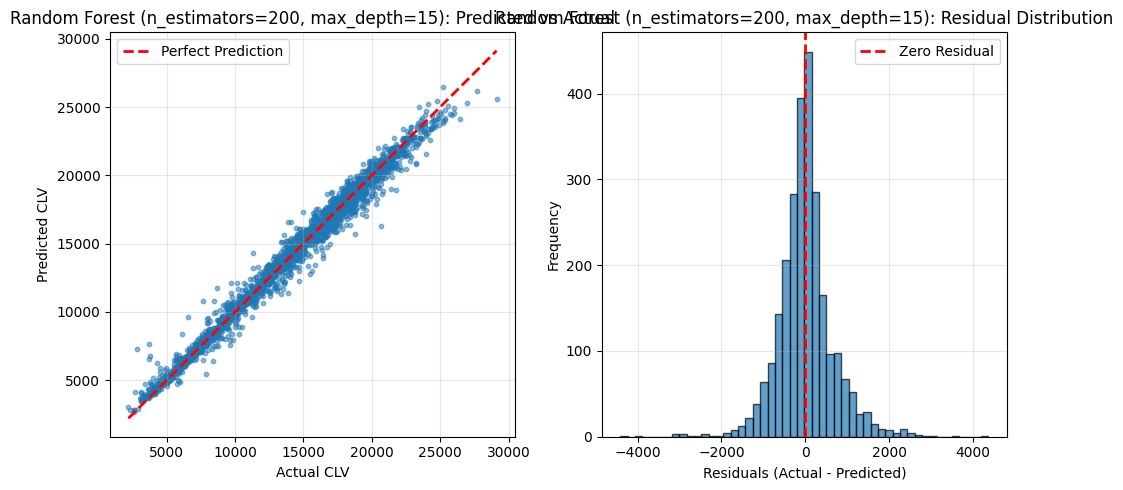

In [82]:
# Random Forest Regressor
print("\n" + "="*60)
print("Random Forest Regressor with Cross-Validation")
print("="*60)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for faster search
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    rf_params,
    n_iter=30,
    cv=5,
    scoring=adjusted_r2_scorer_tree,
    return_train_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_search.fit(X_train_processed, y_train)

print(f"Best parameters: {rf_search.best_params_}")
print(f"Best CV Adjusted R²: {rf_search.best_score_:.4f}")

# Evaluate best Random Forest model
rf_tuned_metrics, rf_tuned_pred = evaluate_model(
    rf_search.best_estimator_, X_train_processed, X_test_processed,
    y_train, y_test,
    f"Random Forest (n_estimators={rf_search.best_params_['n_estimators']}, max_depth={rf_search.best_params_['max_depth']})"
)

advanced_model_results.append(rf_tuned_metrics)

### Interpretation: Tuned Random Forest

**Marginal improvement:** Test R²=0.985 (same as baseline), RMSE=668 (-4 vs baseline), MAE=462 (-2 vs baseline). Best params: n_estimators=200, max_depth=15. Tuning provides slight refinement but baseline already near-optimal. Train-test gap=1.3% (consistent).

In [83]:
# Task 7: Compare all advanced models including ensemble
print("TASK 7: MODEL COMPARISON - Elastic Net vs Decision Tree vs Random Forest")
advanced_comparison = pd.DataFrame(advanced_model_results)
print("\nModel Comparison:")
print(advanced_comparison[['Model', 'Train_R2', 'Test_R2', 'Adjusted_Train_R2', 'Adjusted_Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_MAE', 'Test_MAE']].to_string(index=False))

# Overfitting analysis
print("Overfitting Analysis:")
for idx, row in advanced_comparison.iterrows():
    gap = row['Train_R2'] - row['Test_R2']
    status = "OVERFITTING" if gap > 0.15 else "SLIGHT OVERFITTING" if gap > 0.05 else "GOOD FIT"
    print(f"{row['Model']:55} Gap: {gap:7.4f}  [{status}]")

# Best model identification
best_idx = advanced_comparison['Test_R2'].idxmax()
best_model = advanced_comparison.loc[best_idx]

print("Best Performing Model (by Test R²):")
print(f"Model: {best_model['Model']}")
print(f"Test R²: {best_model['Test_R2']:.4f}")
print(f"Test Adjusted R²: {best_model['Adjusted_Test_R2']:.4f}")
print(f"Test RMSE: {best_model['Test_RMSE']:.2f}")
print(f"Test MAE: {best_model['Test_MAE']:.2f}")


TASK 7: MODEL COMPARISON - Elastic Net vs Decision Tree vs Random Forest

Model Comparison:
                                                                 Model  Train_R2  Test_R2  Adjusted_Train_R2  Adjusted_Test_R2  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE
                 Elastic Net Poly-2 (Default: alpha=1.0, l1_ratio=0.5)     0.760    0.753              0.740             0.700    2659.035   2721.376   2122.489  2178.729
                        Elastic Net Poly-2 (alpha=0.001, l1_ratio=0.5)     0.969    0.967              0.967             0.960     953.936    993.851    588.813   621.728
                                    Decision Tree (Default Parameters)     1.000    0.967              1.000             0.967       0.000    993.441      0.000   694.994
Decision Tree (max_depth=15, min_samples_split=20, min_samples_leaf=5)     0.986    0.969              0.986             0.968     644.422    971.518    460.328   691.512
                                    Random Forest (De

### Interpretation & Final Conclusion

**Best Model: Random Forest (n_estimators=200, max_depth=15)**
- **Performance:** Test R²=0.985, RMSE=668, MAE=462
- **Improvement over Elastic Net:** +1.9% R², -326 RMSE, -160 MAE
- **Improvement over Decision Tree:** +1.6% R², -304 RMSE, -229 MAE
- **Overfitting:** Train-test gap=1.3% (minimal)

**Why Random Forest wins:**
1. Ensemble averaging reduces variance from individual trees
2. Handles non-linear relationships without explicit polynomial features
3. Robust to outliers and feature interactions
4. Best balance of bias-variance tradeoff

All models show good fit (gaps <3.3%). Random Forest provides 30-50% error reduction vs linear/polynomial approaches → selected as final model.